### 1. Import all necessary libraries

In [22]:
import cv2
import math
import random
import numpy as np

from scipy.ndimage import convolve
from matplotlib import pyplot as plt

### 2. Read in image in question

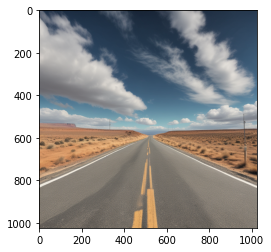

In [23]:
image_path = 'fake_images/fake1.png'
# image_path = 'real_images/real1.png'
image = cv2.imread(image_path)
color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(color_image)

### 3. Grayscale the Image

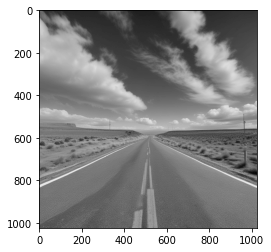

In [24]:
rows, cols = image.shape[:2]
gray_image = np.zeros((rows, cols))

for r in range(rows):
    for c in range(cols):
        gray_image[r, c] = 0.299*image[r, c, 0] + 0.587*image[r, c, 1] + 0.114*image[r, c, 2]

plt.imshow(gray_image, cmap="gray")

### 4. Apply Canny edge filter to extract edges

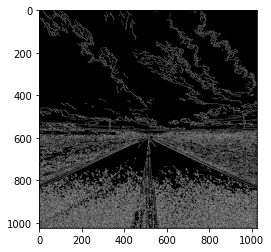

In [25]:
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size,size))
    for x in range(size):
        for y in range(size):
            kernel[x][y] = np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2)/(2*sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def sobel_filters(image):
    x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    y_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    x_edges = convolve(image, x_kernel)
    y_edges = convolve(image, y_kernel)
    output = (x_edges**2 + y_edges**2)**(1/2)
    output = output / output.max() * 255
    theta = np.arctan2(y_edges, x_edges)
    return (output, theta)

def non_max_suppression(image, theta):
    rows, cols = image.shape
    output = np.zeros((rows, cols))
    angle = theta*180. / np.pi
    angle[angle < 0] += 180
    
    for r in range(1, rows-1):
        for c in range(1, cols-1):

            a = None
            b = None

            if (0 <= angle[r, c] < 22.5) or (157.5 <= angle[r, c] <= 180):
                a = image[r, c+1]
                b = image[r, c-1]

            elif (22.5 <= angle[r, c] < 67.5):
                a = image[r+1, c-1]
                b = image[r-1, c+1]

            elif (67.5 <= angle[r, c] < 112.5):
                a = image[r+1, c]
                b = image[r-1, c]

            elif (112.5 <= angle[r, c] < 157.5):
                a = image[r-1, c-1]
                b = image[r+1, c+1]

            if (image[r, c] >= a) and (image[r, c] >= b):
                output[r, c] = image[r, c]

            else:
                output[r, c] = 0

    return output

def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = image.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    rows, cols = image.shape
    res = np.zeros((rows, cols))
    
    weak = 25
    strong = 255
    
    strong_r, strong_c = np.where(image >= highThreshold)
    weak_r, weak_c = np.where((image <= highThreshold) & (image >= lowThreshold))
    
    res[strong_r, strong_c] = strong
    res[weak_r, weak_c] = weak

    return res, weak

def hysteresis(image, weak, strong=255):
    rows, cols = image.shape  

    for r in range(1, rows-1):
        for c in range(1, cols-1):

            if (image[r, c] == weak):
                if ((image[r+1, c-1] == strong) or (image[r+1, c] == strong) or (image[r+1, c+1] == strong)
                    or (image[r, c-1] == strong) or (image[r, c+1] == strong)
                    or (image[r-1, c-1] == strong) or (image[r-1, c] == strong) or (image[r-1, c+1] == strong)):
                    image[r, c] = strong
                else:
                    image[r, c] = 0

    return image

def cannyEdge(image):
    kernel = gaussian_kernel(5, 1.0)
    image = convolve(image, kernel)
    edge_image, theta = sobel_filters(image)
    thin_edge_image = non_max_suppression(edge_image, theta)
    thresholded_img ,weak_pixels = threshold(thin_edge_image)
    canny_image = hysteresis(thresholded_img, weak_pixels)
    return canny_image

canny_image = cannyEdge(gray_image)

plt.imshow(canny_image, cmap="gray")

### 5. Apply Hough Transform to generate lines

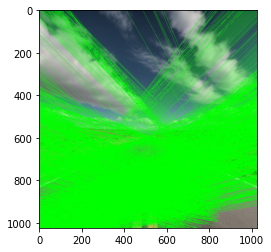

In [26]:
canny_image = np.uint8(canny_image)
display_image1 = np.copy(color_image)
lines=cv2.HoughLines(canny_image, 1, np.pi/180, 225)

best_lines = []

for line in lines:
    r, theta = line[0]
    degrees = theta*360/2/np.pi
    if (degrees > 10 and degrees < 80) or (degrees > 100 and degrees < 170):
        x0 = np.cos(theta)*r
        y0 = np.sin(theta)*r
        x1 = int(x0 + 1000*-1*np.sin(theta))
        y1 = int(y0 + 1000*np.cos(theta))
        x2 = int(x0 - 1000*-1*np.sin(theta))
        y2 = int(y0 - 1000*np.cos(theta))
        best_lines.append((x1, y1, x2, y2))
        cv2.line(display_image1,(x1,y1),(x2,y2),(0,255,0),1)
    else:
        continue

plt.imshow(display_image1)

### 6. Apply RANSAC to find estimated vanishing point

In [27]:
def RANSAC(lines):

    max_count = 0
    vanishing_points = {}

    for i in range(100):
        line1, line2 = random.sample(lines, 2)
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2

        a1 = y2 - y1
        b1 = x1 - x2
        c1 = a1*x1 + b1*y1

        a2 = y4 - y3
        b2 = x3 - x4
        c2 = a2*x3 + b2*y3

        det = a1*b2 - a2*b1

        if det != 0:
            x_intersect = (b2*c1 - b1*c2)/det
            y_intersect = (a1*c2 - a2*c1)/det

            count = 0
            for line in lines:
                x1, y1, x2, y2 = line

                a = y2 - y1
                b = x1 - x2
                c = -a*x1 - b*y1

                dist = abs((a * x_intersect + b * y_intersect + c)) / np.sqrt(a**2 + b**2)
                if dist < 0.5:
                    count += 1
            if count > max_count:
                max_count = count
                vanishing_points[(x_intersect, y_intersect)] = count
        else:
            continue

    return vanishing_points

iterations = 50
total_weight = 0
x = 0
y = 0

for _ in range(iterations):
    vanishingPoints = RANSAC(best_lines)

    for point, weight in vanishingPoints.items():
        if point[0] < 0 or point[1] < 0 or point[0] > rows or point[1] > cols:
            continue
        x += weight*point[0]
        y += weight*point[1]
        total_weight += weight

x_estimate, y_estimate = np.round(x/total_weight), np.round(y/total_weight)


### 7. User input ground truth vanishing point

True point: (524, 581)
Estimated Point: (494, 827)
Fake


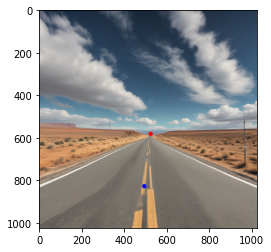

In [28]:
def userPoint(event, x, y, flags, params):
    global selected_point
    if event == cv2.EVENT_LBUTTONDOWN:
        selected_point = (x, y)

selected_point = None
cv2.namedWindow('image')
cv2.setMouseCallback('image', userPoint)

while True:
    cv2.imshow('image', image)
    key = cv2.waitKey(1) & 0xFF
    if selected_point is not None:
        break

# Save point once it's selected
if selected_point is not None:
    print("True point:", selected_point)
else:
    print("No point selected.")
cv2.destroyAllWindows()

print(f"Estimated Point: ({int(x_estimate)}, {int(y_estimate)})")
radius = 90
x_true, y_true = selected_point
if (x_estimate - x_true)**2 + (y_estimate - y_true)**2 < radius**2:
    print("Real")
else:
    print("Fake")

display_image2 = np.copy(color_image)
cv2.circle(display_image2, (int(x_estimate), int(y_estimate)), radius=10, color=(0, 0, 255), thickness=-1)
cv2.circle(display_image2, (int(x_true), int(y_true)), radius=10, color=(255, 0, 0), thickness=-1)

plt.imshow(display_image2)